# Analysis of Mid-IR metalens based on silicon nanopillars

## Initialization

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tidy3d as td
import tidy3d.web as web
import scienceplots

In [ ]:
# 0 Define a FreqRange object with desired wavelengths
lda0 = 10.6  # operation wavelength
freq0 = td.C_0 / lda0  # operation frequency
fwidth = # Define bandwidth
fr = td.FreqRange(freq0=freq0, fwidth=freq0 / 10)

- Note: Tidy3D currently don't support a single ``inf`` value in bounds for ``Box``. To construct a semi-infinite ``Box``, please supply a large enough number instead of ``inf``. For example, a location extending outside of the Simulation domain (including PML)

In [7]:
# 1 Computational Domain Size
P = 6.2  # period of the unit cell
h = 6.8  # height of the pillar
Lz = h + 1.2 * lda0  # simulation domain size in z direction

# 2 Grid Resolution
min_steps_per_wvl = 12  # minimum steps per wavelength for the grid
grid_spec = td.GridSpec.auto(
    min_steps_per_wvl=min_steps_per_wvl, 
    wavelength=lda0
)

# 3 Structures
n_si = 3.43  # refractive index of silicon
si = td.Medium(permittivity=n_si**2)

# define a function to create pillar given diameter
def make_unit_cell(D):
    pillar_geo = td.Cylinder(
        center=(0, 0, h / 2), 
        radius=D / 2, 
        length=h
    )
    pillar = td.Structure(
        geometry=pillar_geo, 
        medium=si
    )

    return pillar

# Define substrate
inf_eff = 1e5  # effective infinity
substrate_geo = td.Box.from_bounds(
    rmin=(-inf_eff, -inf_eff, -inf_eff), 
    rmax=(inf_eff, inf_eff, 0)
)
substrate = td.Structure(
    geometry=substrate_geo, 
    medium=si
)

# 4 Sources
plane_wave = td.PlaneWave(
    source_time=fr.to_gaussian_pulse(),
    size=(td.inf, td.inf, 0),
    center=(0, 0, -0.1 * lda0),
    direction="+",
)

# 5 Monitors
monitor_t = td.DiffractionMonitor(
    center=[0, 0, h + 0.5 * lda0], 
    size=[td.inf, td.inf, 0], freqs=[freq0], 
    name="t"
)

# 6 Run Time
run_time = 5e-12

# 7 Boundary Conditions
boundary_spec = td.BoundarySpec(
    x=td.Boundary.periodic(),
    y=td.Boundary.periodic(),
    z=td.Boundary(minus=td.PML(), plus=td.PML()),
)

## Simulation

In [4]:
# define a function to create unit cell simulation given pillar diameter
def make_unit_cell_sim(D):
    sim = td.Simulation(
        center=(0, 0, h / 2),
        size=(P, P, Lz),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl, wavelength=lda0),
        structures=[make_unit_cell(D), substrate],
        sources=[plane_wave],
        monitors=[monitor_t],
        run_time=run_time,
        boundary_spec=boundary_spec,  # pml is applied to z direction. x and y directions are periodic
    )

    return sim

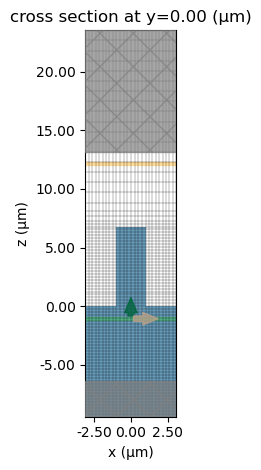

In [12]:
# create an example simulation and visualize the setup and grid
sim = make_unit_cell_sim(2)
ax = sim.plot(y=0) # plots the geometry
sim.plot_grid(y=0, ax=ax) # plots the grid resolution
ax.set_aspect(0.8)
plt.show()


In [14]:
# parameter sweep: D=[1.5, 3.6]
D_list = np.linspace(1.5, 3.6, 20)  # values of pillar diameter to be simulated
sims = {f"D={D:.3f}": make_unit_cell_sim(D) for D in D_list}  # construct simulation batch
print(sims.keys())

dict_keys(['D=1.500', 'D=1.611', 'D=1.721', 'D=1.832', 'D=1.942', 'D=2.053', 'D=2.163', 'D=2.274', 'D=2.384', 'D=2.495', 'D=2.605', 'D=2.716', 'D=2.826', 'D=2.937', 'D=3.047', 'D=3.158', 'D=3.268', 'D=3.379', 'D=3.489', 'D=3.600'])


In [15]:
# submit simulation batch to the server
batch = web.Batch(simulations=sims, verbose=True)
batch_results = batch.run(path_dir="data")

Output()

19:36:36 EDT Started working on Batch containing 20 tasks.

19:36:52 EDT Maximum FlexCredit cost: 0.500 for the whole batch.

             Use 'Batch.real_cost()' to get the billed FlexCredit cost after the
             Batch has completed.

Output()

19:37:07 EDT Batch complete.

Output()

## Postprocess

In [20]:
sim_data = batch_results["D=2.053"]

In [ ]:
# extract the complex transmission coefficient
t = np.zeros(len(D_list), dtype="complex")
for i, D in enumerate(D_list):
    sim_data = batch_results[f"D={D:.3f}"] # go though each simulation result
    t[i] = np.array(sim_data["t"].amps.sel(f=freq0, polarization="p"))[0][0] # extract complex transmission at freq0

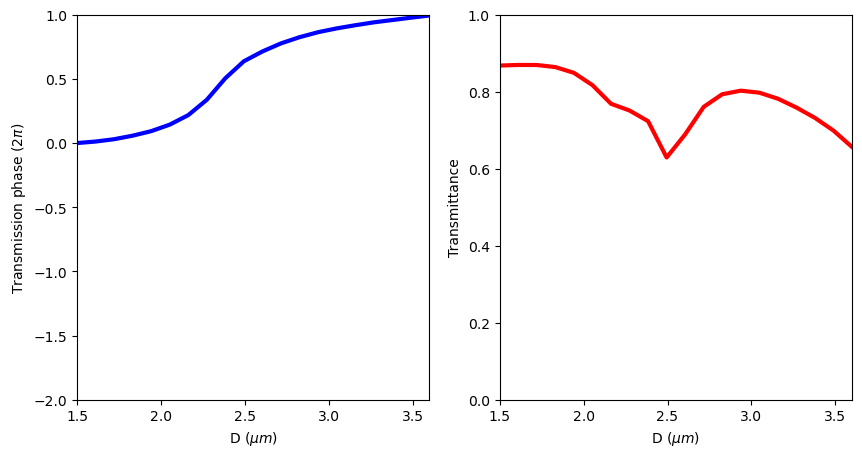

In [39]:
# plot the transmission phase
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
theta = np.unwrap(np.angle(t))
theta = theta - theta[0]
ax1.plot(D_list, theta / (2 * np.pi), linewidth=3, c="blue")
ax1.set_xlim(np.min(D_list), np.max(D_list))
ax1.set_ylim(-2, 1)
ax1.set_xlabel(r"D ($\mu m$)")
ax1.set_ylabel(r"Transmission phase ($2\pi$)")

# plot the transmittance
ax2.plot(D_list, np.abs(t), linewidth=3, c="red")
ax2.set_xlim(np.min(D_list), np.max(D_list))
ax2.set_ylim(0, 1)
ax2.set_xlabel(r"D ($\mu m$)")
ax2.set_ylabel("Transmittance")
plt.show()
ax2.plot(D_list, np.abs(t), linewidth=3, c="red")
ax2.set_xlim(np.min(D_list), np.max(D_list))
ax2.set_ylim(0, 1)
ax2.set_xlabel(r"D ($\mu m$)")
ax2.set_ylabel("Transmittance")
plt.show()